# Introduction

##### В този Notebook ще разгледаме данните от Home Credit Default Risk Competition, проведено в Kaggle и ще се опитаме да предскажем дали даден клиент ще си изплати заема.

За състезанието са предоставен 7 различни източника на данни, но ние ще разгледаме само главния трейнинг датасет с информация за всеки клиент за заем на Home Credit. За всеки заем има отделен ред в таблицата с идентификатор SK_ID_CURR. В тези данни има колона TARGET със стойности 0 (ако заемът е изплатен) и 1 (ако заемът не е изплатен).

In [1]:
import sys

import sklearn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

In [2]:
np.warnings.filterwarnings('ignore')

In [3]:
# training data
train = pd.read_csv('application_train.csv', index_col=['SK_ID_CURR'])

In [4]:
train.shape

(307511, 121)

In [5]:
train.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis

Exploratory Data Analysis е процес, в който търсим аномалии, модели и зависимости между фичърите. Главната цел е да разберем значението на фичърите.

### Explore TARGET column

In [6]:
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

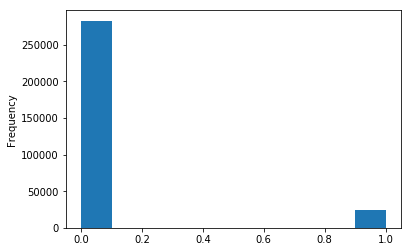

In [7]:
train['TARGET'].astype(int).plot.hist();

Заемите, които са били изплатени, са доста повече от неизплатените. Този дисбаланс би могъл да представлява проблем.

### Examine Missing Data

In [8]:
# calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("The dataframe has " + str(df.shape[1]) + " columns.\n"      
               + str(mis_val_table_ren_columns.shape[0]) +
              " of them have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
missing_values = missing_values_table(train)
missing_values.head(20)

The dataframe has 121 columns.
67 of them have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Виждаме, че има доста голям процент на липсващи стойности, но е твърде рано, за да решим дали да премахнем някои колони, защотото: 1) Можем да използваме XGBoost, който се справя с липсващите колони 2) Не знаем коя колона, колко голямо значение има

### Examine Column Types

In [10]:
train.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

In [11]:
# Number of unique classes in each object column
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0).sort_values()

NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
CODE_GENDER                    3
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

За сега ще ги оставим така. Малко по-късно преди да направим LabelEncoder и OneHotEncoder ще ги разгледаме по-подробно

### Explore for Outliers

In [12]:
train["DAYS_BIRTH"].head()

SK_ID_CURR
100002    -9461
100003   -16765
100004   -19046
100006   -19005
100007   -19932
Name: DAYS_BIRTH, dtype: int64

Стойностите са отрицателни, защото това е възрастта на клиента в дни в момента на постъпление.
Можем да ги умножим по -1 и да разделим на броя дни в годината, за да получим приблизителните години.

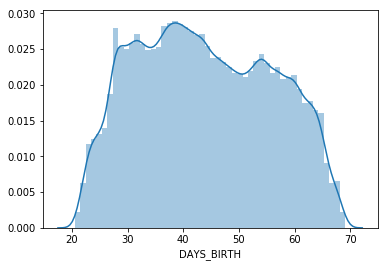

In [13]:
sns.distplot(train['DAYS_BIRTH']/-365);

In [14]:
(train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Тук нямаме аномалии

In [15]:
(train['DAYS_EMPLOYED']/365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

Това вече изглежда странно. Максималната стойност е около 1000 работни години.

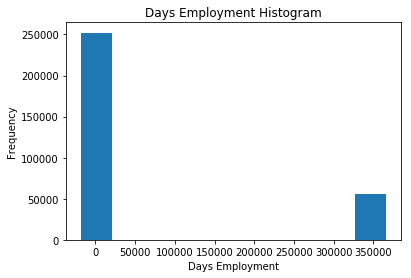

In [16]:
train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Ще направим нова колона само за аномалиите (евентуално ако по-късно ни потрябват тези стойности) и ще ги превърнем в 'nan' в оригиналната колона.

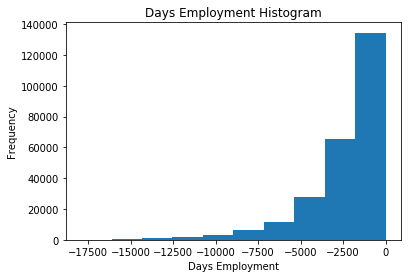

In [17]:
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243

train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Така вече графиката изглежда по-добре

In [18]:
# Check other columns starting with DAYS for outliers

train['DAYS_REGISTRATION'].describe()

count    307511.000000
mean      -4986.120328
std        3522.886321
min      -24672.000000
25%       -7479.500000
50%       -4504.000000
75%       -2010.000000
max           0.000000
Name: DAYS_REGISTRATION, dtype: float64

In [19]:
train['DAYS_LAST_PHONE_CHANGE'].describe()

count    307510.000000
mean       -962.858788
std         826.808487
min       -4292.000000
25%       -1570.000000
50%        -757.000000
75%        -274.000000
max           0.000000
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

In [20]:
train['DAYS_ID_PUBLISH'].describe()

count    307511.000000
mean      -2994.202373
std        1509.450419
min       -7197.000000
25%       -4299.000000
50%       -3254.000000
75%       -1720.000000
max           0.000000
Name: DAYS_ID_PUBLISH, dtype: float64

Виждаме, че във видяните по-горе колони не се виждат някакви очевидни outliers.

### Examine Correlations

In [21]:
correlations = train.corr()['TARGET'].sort_values()

print("Most Possitive: \n", correlations.tail(10), '\n')
print("Most Negative: \n", correlations.head(10))

Most Possitive: 
 REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64 

Most Negative: 
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_ANOM           -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64


DAYS_BIRTH и DAYS_EMPLOYED имат най-голямо влияние върху модела

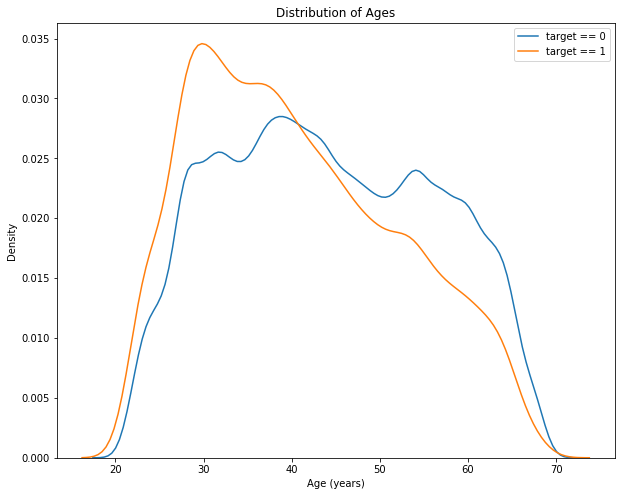

In [22]:
train['DAYS_BIRTH']=abs(train['DAYS_BIRTH'])
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

От графиката се вижда, че повече млади хора не си плащат заемите, и съответно повечето възрастни - ги плащат

Може да групираме годините в интервали от 5 години. Така ще видим съотношението на кредитие, които не са изплатени във всяка категория

In [23]:
age_data = train[['TARGET', 'DAYS_BIRTH']].copy()
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
SK_ID_CURR,,,,
100002,1,9461,25.920548,"(25.0, 30.0]"
100003,0,16765,45.931507,"(45.0, 50.0]"
100004,0,19046,52.180822,"(50.0, 55.0]"
100006,0,19005,52.068493,"(50.0, 55.0]"
100007,0,19932,54.608219,"(50.0, 55.0]"
100008,0,16941,46.413699,"(45.0, 50.0]"
100009,0,13778,37.747945,"(35.0, 40.0]"
100010,0,18850,51.643836,"(50.0, 55.0]"
100011,0,20099,55.065753,"(55.0, 60.0]"


In [24]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


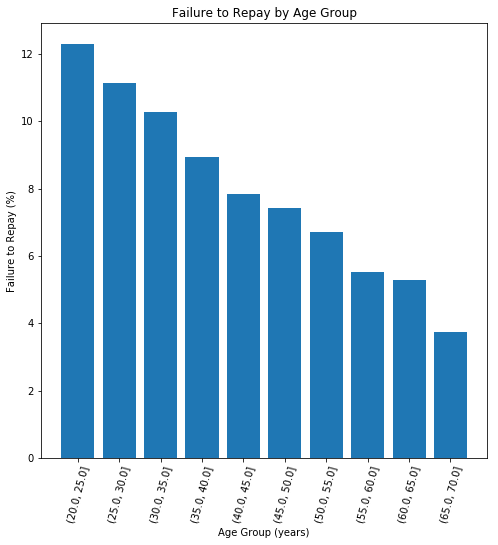

In [25]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

Тук още по-ясно се вижда, че колкото по-млади са клиентите, толкова по-рядко си плащат заемите. Повече от 10% от първите 3 категории имат тенденция да не ти плащат заемите, докато при най-възрастните процента е под 4.

Нека разгледаме фичърите с най-голямо отрицателно влияние. Това са: EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3

In [26]:
# Show the correlations
ext_data = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Може да видим разпределението на тези фичъри спрямо TARGET

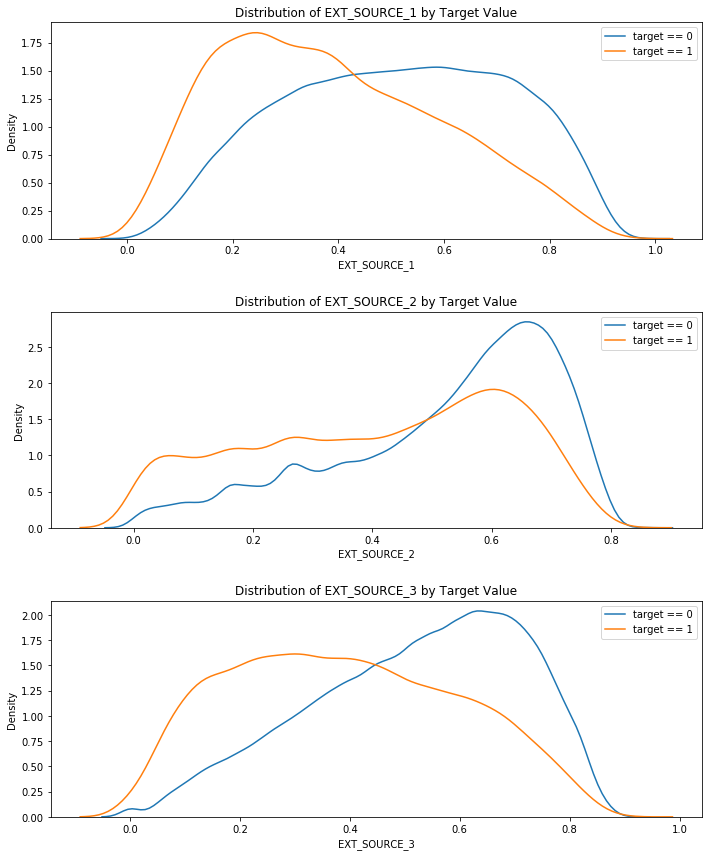

In [27]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

Най-голямо влияние върху TARGET оказва EXT_SOURCE_3. Вероятно е този фичър да има връзка (макар и слаба) с връщането на заемите.

### Pair Plots

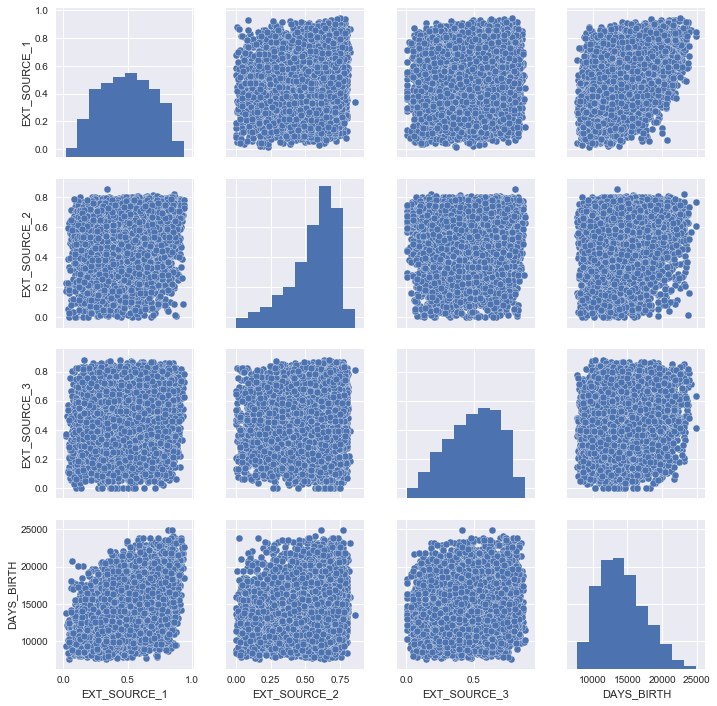

In [28]:
#scatterplot
part_train = train.dropna()
sns.set()
cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
sns.pairplot(part_train.fillna(0)[cols], size=2.5)
plt.show()

#### Май няма смисъл

# Feature Engineering

Нека отново погледнем уникалните стойности в object колоните

In [29]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0).sort_values()

NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
CODE_GENDER                    3
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

In [30]:
# We see that ORGANIZATION_TYPE has more than 50 different values
# so for now we will drop the column, because after one hot encoding
# We will have 50+ columns only for ORGANIZATION TYPE

train.drop(columns=["ORGANIZATION_TYPE"], inplace=True)

# Get categorical column names for cols with more than 2 uniqe values
# We will OneHotEncode those columns later.
categorical_cols = train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
categorical_cols = categorical_cols[categorical_cols>2].index

Тези, които са само с две уникални стойности, може да ги трансформираме в колони съдържащи булеви стойности (0, 1). Това ще го направим с Label encoding. Останалите колони ще ги трансформираме чрез One-Hot-Encodint (get dummies).

In [31]:
# labelEncode the object cols with less than 2 unique values
le = LabelEncoder()
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            train[col] = le.transform(train[col])

In [32]:
train.select_dtypes('object').isnull().sum()

CODE_GENDER                        0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

Виждаме, че има колони, които имат голям процент празни стойности. За сега ще махнем тези колони (OCCUPATION_TYPE, FONDKAPREMONT_MODE, HOUSETYPE_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE). Колоната NAME_TYPE_SUITE има сравнително малко празни стойности. Можем да махнем тези 1292 реда от dataset-a, без да окаже голямо влияние върху количеството данни, с което тренираме.

In [33]:
train.drop(columns=["OCCUPATION_TYPE", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE"], inplace=True)

train = train[train['NAME_TYPE_SUITE'].notnull()]

In [34]:
train.select_dtypes('object').isnull().sum()

CODE_GENDER                   0
NAME_TYPE_SUITE               0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
WEEKDAY_APPR_PROCESS_START    0
dtype: int64

Вече нямаме празни стойности в object колоните. Да видим какво се случва в останалите колони.

In [35]:
train.isnull().sum().sort_values(ascending=False)

COMMONAREA_MEDI                213989
COMMONAREA_AVG                 213989
COMMONAREA_MODE                213989
NONLIVINGAPARTMENTS_MEDI       212655
NONLIVINGAPARTMENTS_MODE       212655
NONLIVINGAPARTMENTS_AVG        212655
LIVINGAPARTMENTS_AVG           209350
LIVINGAPARTMENTS_MEDI          209350
LIVINGAPARTMENTS_MODE          209350
FLOORSMIN_MEDI                 207800
FLOORSMIN_MODE                 207800
FLOORSMIN_AVG                  207800
YEARS_BUILD_MODE               203660
YEARS_BUILD_MEDI               203660
YEARS_BUILD_AVG                203660
OWN_CAR_AGE                    202048
LANDAREA_MEDI                  181869
LANDAREA_AVG                   181869
LANDAREA_MODE                  181869
BASEMENTAREA_AVG               179239
BASEMENTAREA_MODE              179239
BASEMENTAREA_MEDI              179239
EXT_SOURCE_1                   172652
NONLIVINGAREA_AVG              169016
NONLIVINGAREA_MEDI             169016
NONLIVINGAREA_MODE             169016
ELEVATORS_MO

Виждаме, че има доста колони с празни стойности. Тъй като са числови, можем за момента да заместим празните полета с 0.

In [36]:
train.fillna(0, inplace=True)
train_target = train["TARGET"]
train_features = train.drop(columns=["TARGET"])

In [37]:
# get categorical columns
categorical_cols = train_features.select_dtypes("object").columns
print(categorical_cols)

Index(['CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'WEEKDAY_APPR_PROCESS_START'],
      dtype='object')


In [38]:
# label encode the rest of the categorical columns
for col in categorical_cols:
    le.fit(train_features[col])
    train_features[col] = le.transform(train_features[col])

label_encoded = train_features[categorical_cols]
label_encoded.head(10)

,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START
SK_ID_CURR,,,,,,,
100002,1,6,7,4,3,1,6
100003,0,1,4,1,1,1,1
100004,1,6,7,4,3,1,1
100006,0,6,7,4,0,1,6
100007,1,6,7,4,3,1,4
100008,1,5,4,4,1,1,6
100009,0,6,1,1,1,1,3
100010,1,6,4,1,1,1,1
100011,0,0,3,4,1,1,6


In [39]:
# OneHotEncode these columns 
one_hot_enc = OneHotEncoder().fit(label_encoded)

one_hot_enc.transform(label_encoded).shape

(306219, 41)

От останалите 7 категорийни колони, след OneHotEncode имаме 41 нови колони. Сега можем да махнем оригиналните колони от трейнинг сета и да добавим новите.

In [40]:
train_features.drop(columns=categorical_cols, inplace=True)

train_features = pd.np.concatenate([train_features,one_hot_enc.transform(label_encoded).todense()], axis=1)

In [41]:
train_features

matrix([[0, 0, 1, ..., 0.0, 0.0, 1.0],
        [0, 0, 0, ..., 0.0, 0.0, 0.0],
        [1, 1, 1, ..., 0.0, 0.0, 0.0],
        ...,
        [0, 0, 1, ..., 1.0, 0.0, 0.0],
        [0, 0, 1, ..., 0.0, 0.0, 1.0],
        [0, 0, 0, ..., 1.0, 0.0, 0.0]], dtype=object)

# Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_features, 
                                                    train_target, 
                                                    test_size=0.3, 
                                                    random_state=4330)

print("Shape of x_train: ", x_train.shape, "\nShape of x_test: ", x_test.shape, "\nShape of y_train: ", y_train.shape, "\nShape of y_test: ", y_test.shape)

Shape of x_train:  (214353, 149) 
Shape of x_test:  (91866, 149) 
Shape of y_train:  (214353,) 
Shape of y_test:  (91866,)


In [43]:
# Make the model with the specified regulari zation parameter
log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(x_train, y_train)

print("Train Score: ", log_reg.score(x_train, y_train))
print("Test Score: ", log_reg.score(x_test, y_test))

Train Score:  0.9198285071820782
Test Score:  0.9175973700825115


Получаваме доста добър резултат. 

# Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators=100, max_depth=10)

random_forest.fit(x_train, y_train)

print("Train score: ", random_forest.score(x_train, y_train))
print("Test score: ", random_forest.score(x_test, y_test))

Train score:  0.9198378375856647
Test score:  0.9175973700825115


## Polynomial Features



In [48]:
# Make a new dataframe for polynomial features, containing the most important features.
poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree = 3)
poly_transformer.fit(poly_features)
poly_features = poly_transformer.transform(poly_features)
poly_features.shape

(306219, 35)

In [49]:
# Get the names of the newly created features.
poly_transformer.get_feature_names(
    input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

In [50]:
# poly_features = pd.DataFrame(
#     poly_features, 
#     columns = poly_transformer.get_feature_names(
#                                                 ['EXT_SOURCE_1',
#                                                  'EXT_SOURCE_2', 
#                                                  'EXT_SOURCE_3',
#                                                  'DAYS_BIRTH'
#                                                 ])
#     )
#Concatenate poly features, one hot encoded cols, and the other columns of the DF.
unneeded_cols = categorical_cols.tolist() + ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH','TARGET']
train_poly = pd.np.concatenate([poly_features, one_hot_enc.transform(label_encoded).todense(), train.drop(columns=unneeded_cols) ], axis=1)

In [51]:
poly_features.shape, train_poly.shape, train.shape, train.drop(columns=unneeded_cols)

((306219, 35),
 (306219, 180),
 (306219, 116),
             NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
 SK_ID_CURR                                                                    
 100002                       0             0                1             0   
 100003                       0             0                0             0   
 100004                       1             1                1             0   
 100006                       0             0                1             0   
 100007                       0             0                1             0   
 100008                       0             0                1             0   
 100009                       0             1                1             1   
 100010                       0             1                1             0   
 100011                       0             0                1             0   
 100012                       1             0                1           

In [52]:
x_train, x_test, y_train, y_test = train_test_split(train_poly, 
                                                    train_target, 
                                                    test_size=0.5, 
                                                    random_state=4330)

log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(x_train, y_train)

print("Train Score: ", log_reg.score(x_train, y_train))
print("Test Score: ", log_reg.score(x_test, y_test))

Train Score:  0.9195801683767774
Test Score:  0.9187381621056756
